In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
import numpy as np
import itertools
import seaborn
from sklearn.metrics import roc_auc_score
from experiments.libs import loaders
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from xgboost import XGBModel

from lightgbm import LGBMClassifier

import mne
from scipy.io import loadmat

from itertools import zip_longest
from copy import deepcopy

from matplotlib import pyplot as plt
%matplotlib inline

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
filepath = '/fileshare/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
srate = 240 # Hz
# Filtered 0.1 - 60Hz

In [3]:
def target_loc_series_from(stimtype_series):
    stim_diff = stimtype_series.diff()
    loc = stim_diff[stim_diff==1].index
    return pd.Series(loc, index=loc)

In [12]:
def target_distance(stimtype_series):
    loc = target_loc_series_from(stimtype_series)
    return (loc - loc.shift(1).fillna(0))

In [13]:
def create_event_frame(flash_series, stimtype_series):
    diff_seq = (flash_series.diff()
                            .fillna(flash_series)) # First event will be missing so fill with 1
    return pd.DataFrame({'flash_onset':diff_seq, 
                         'stim_type': stimtype_series})

In [14]:
def epoch_generator(eeg_data, event_df, duration=0.8, srate=240):
    """ Yields epoch as well as classification label
    """
    offset = int(np.round(duration * srate))
    for idx in event_df[event_df['flash_onset']==1].index:
        data = eeg_data[idx:idx+offset, :] - eeg_data[idx, :] # Removing offset
        yield data, event_df['stim_type'].at[idx]

In [15]:
def append_ntt_distance(event_df):
    """ Append the non-target to target distance
    """
    target_loc_series = (target_loc_series_from(event_df['stim_type']).reindex(event_df.index)
                                                                      .ffill())
    return event_df.assign(ntt_distance=(event_df.index - target_loc_series).fillna(target_loc_series.max()))

In [20]:
def drop_close_targets(event_df, samples_distance=126):
    """ Removes targets that are too close together temporaly
    """
    index_to_drop = event_df[(event_df['flash_onset']>0)&
                             (event_df['stim_type']>0)& # 1 target 0 non-target
                             (event_df['target_dist']<=samples_distance)].index
    return event_df.drop(index_to_drop)

In [21]:
def drop_close_non_targets(event_df, samples_distance=84):
    """ Removes non-targets that are too close to target temporaly
    """
    index_to_drop = event_df[(event_df['flash_onset']>0)&
                             (event_df['stim_type']<1)& # 1 target 0 non-target
                             (event_df['ntt_distance']<=samples_distance)].index
    return event_df.drop(index_to_drop)

In [27]:
def dataset_epoch_generator(filename, srate=240):
    dataset_dict = loadmat(filename)
    num_runs = dataset_dict['Flashing'].shape[0]
    
    for run in range(num_runs):
        eeg_array = dataset_dict['Signal'][run,:,:]
        flash_series = pd.Series(dataset_dict['Flashing'][run, :])
        stimtype_series = pd.Series(dataset_dict['StimulusType'][run, :])
        event_df = (create_event_frame(flash_series, stimtype_series).
                    assign(target_dist=target_distance(stimtype_series)).
                    pipe(append_ntt_distance).
                    pipe(drop_close_targets).
                    pipe(drop_close_non_targets))

        # Transforming from time by channel to channel by time
        eeg_array = mne.filter.filter_data(eeg_array.astype(np.float64).T, srate, None, 18, verbose=False).T
        for epoch in epoch_generator(eeg_array, event_df, duration=0.8, srate=srate):
            yield epoch

In [28]:
egen = dataset_epoch_generator(filepath, srate=srate)
data_list = list(egen)

In [29]:
len(data_list)

10208

In [30]:
X = np.array([d[0][::6].ravel() for d in data_list])

In [31]:
y = np.array([d[1] for d in data_list])

In [32]:
X.shape

(10208, 2048)

In [33]:
y.shape

(10208,)

In [34]:
pipeline_steps = [('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [35]:
featurisers = [('continuous', continuous_pipeline)]

In [36]:
xgb_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=2, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                subsample=1))]) 

In [37]:
lgbm_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', LGBMClassifier(num_leaves=2**2,
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                subsample=1))]) 

In [38]:
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ123456789_'
stim_code_translation_dict = dict((l, (i%6+1, int(np.floor(i/6)+7)) ) for i, l in enumerate(letters))

In [39]:
def event_frame_from(stim_code, target_letter, stim_code_translation_dict):
    diff_seq = stim_code.diff()
    diff_seq = diff_seq.fillna(stim_code)
    
    target_codes = stim_code_translation_dict[target_letter]
    target_index = diff_seq[diff_seq.isin(target_codes)].index
    stimtype_series = pd.Series(0, index=stim_code.index)
    stimtype_series[target_index]=1
    diff_seq = (diff_seq/diff_seq.abs()).fillna(0)
    
    return pd.DataFrame({'flash_onset':diff_seq, 
                         'stim_type': stimtype_series})

In [40]:
test_filename = '/fileshare/BCI_Comp_III_Wads_2004/Subject_A_Test.mat'
labels_filename = '/fileshare/BCI_Comp_III_Wads_2004/true_labels_a.txt'

In [41]:
def read_labels(filename):
    return open(filename).readline().strip()

In [60]:
def test_dataset_epoch_generator(data_filename, labels_filename, stim_code_translation_dict, srate=240):
    dataset_dict = loadmat(data_filename)
    labels = read_labels(labels_filename)
    
    for run, target in enumerate(labels):
        eeg_array = dataset_dict['Signal'][run,:,:]
        stimcode_series = pd.Series(dataset_dict['StimulusCode'][run, :])
        event_df = (event_frame_from(stimcode_series, target, stim_code_translation_dict).
                    pipe(lambda x: x.assign(target_dist=target_distance(x['stim_type']))).
                    pipe(append_ntt_distance).
                    pipe(drop_close_targets).
                    pipe(drop_close_non_targets))
        
        # Transforming from time by channel to channel by time
        eeg_array = mne.filter.filter_data(eeg_array.astype(np.float64).T, srate, None, 18, verbose=False).T
        for epoch in epoch_generator(eeg_array, event_df, duration=0.8, srate=srate):
            yield epoch

In [61]:
data_gen = test_dataset_epoch_generator(test_filename, labels_filename, stim_code_translation_dict)

In [62]:
data_list = list(data_gen)

In [63]:
X_test = np.array([d[0][::6].ravel() for d in data_list])

In [64]:
y_test = np.array([d[1] for d in data_list])

In [65]:
X_test.shape

(12045, 2048)

In [66]:
%%time
xgb_clf_pipeline.fit(X, y)

CPU times: user 1min 35s, sys: 764 ms, total: 1min 36s
Wall time: 5.4 s


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2, seed=0, silent=True, subsample=1))])

In [67]:
y_pred = xgb_clf_pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

0.68251896814231094

In [68]:
%%time
lgbm_clf_pipeline.fit(X, y)

CPU times: user 22.1 s, sys: 496 ms, total: 22.6 s
Wall time: 2.64 s


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_un...   subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False))])

In [69]:
y_pred = lgbm_clf_pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

0.68410165060258266

In [55]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [58]:
xgb_clf_pipeline.fit(X,y)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2, seed=0, silent=True, subsample=1))])

In [360]:
def run_train_retrain_comparison(model, X, y, X_test, y_test):
    retrain_model = deepcopy(model)
    historical_X = [X]
    historical_y = [y]
    prev_size = X.shape[0]
    train_auc=[]
    retrain_auc=[]
    for X_chunk, y_chunk in  zip(grouper(X_test, 15*12), grouper(y_test, 15*12)):
        X_chunk_array = np.array(X_chunk)
        y_chunk_array = np.array(y_chunk)
        
        try: # TODO: Fix grouper
            y_pred = model.predict_proba(X_chunk_array)
            train_auc.append(roc_auc_score(y_chunk_array, y_pred[:, 1]))
            print('Train ', train_auc[-1])

            y_pred = retrain_model.predict_proba(X_chunk_array)
            retrain_auc.append(roc_auc_score(y_chunk_array, y_pred[:, 1]))
            print('Retrain ', retrain_auc[-1])

            historical_X.append(X_chunk_array)
            historical_y.append(y_chunk_array)

            new_train_X  = np.concatenate(historical_X)
            retrain_model.fit(new_train_X[-prev_size:], np.concatenate(historical_y)[-prev_size:])
        except:
            print('Finished')
            print(X_chunk_array.shape)
            print(y_chunk_array.shape)
        
    return pd.DataFrame({
        'train_auc':train_auc,
        'retrain_auc':retrain_auc
    })

In [361]:
df = run_train_retrain_comparison(xgb_clf_pipeline, X, y, X_test, y_test)

Train  0.730075359671
Retrain  0.730075359671
Train  0.682010135135
Retrain  0.672086148649
Train  0.633487654321
Retrain  0.639660493827
Train  0.728888888889
Retrain  0.715333333333
Train  0.691579371475
Retrain  0.691579371475
Train  0.664273648649
Retrain  0.661951013514
Train  0.621346611821
Retrain  0.620913617666
Train  0.654254167569
Retrain  0.659017103269
Train  0.572505138159
Retrain  0.548527060973
Train  0.719439290868
Retrain  0.730364873222
Train  0.677787162162
Retrain  0.614653716216
Train  0.742344883159
Retrain  0.719178082192
Train  0.739209865266
Retrain  0.719342315597
Train  0.771593485879
Retrain  0.784374355803
Train  0.724444444444
Retrain  0.709777777778
Train  0.630872483221
Retrain  0.674171898679
Train  0.704391891892
Retrain  0.669552364865
Train  0.692228406514
Retrain  0.687280972995
Train  0.693994062571
Retrain  0.720712491436
Train  0.665812807882
Retrain  0.71645320197
Train  0.592350520455
Retrain  0.626966836117
Train  0.669102534825
Retrain  0.65

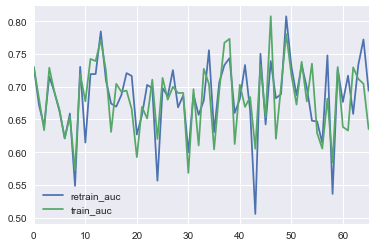

In [362]:
df.plot()

In [363]:
df.mean()

retrain_auc    0.684195
train_auc      0.681756
dtype: float64

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


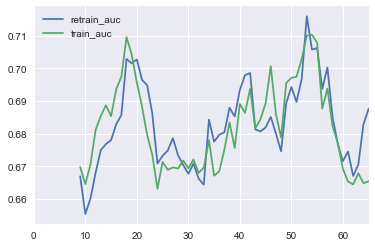

In [364]:
pd.rolling_mean(df, 10).plot()

In [338]:
%time df = run_train_retrain_comparison(lgbm_clf_pipeline, X, y, X_test, y_test)

Train  0.745147293903
Retrain  0.745147293903
Train  0.675464527027
Retrain  0.681798986486
Train  0.614969135802
Retrain  0.640046296296
Train  0.719777777778
Retrain  0.745777777778
Train  0.696414182111
Retrain  0.705076551168
Train  0.670608108108
Retrain  0.648015202703
Train  0.649924226023
Retrain  0.685646243776
Train  0.640831348777
Retrain  0.66291405066
Train  0.576158940397
Retrain  0.546471797214
Train  0.719439290868
Retrain  0.756132756133
Train  0.688978040541
Retrain  0.673141891892
Train  0.745366639807
Retrain  0.722804190169
Train  0.760675953414
Retrain  0.724594656314
Train  0.759637188209
Retrain  0.794269222841
Train  0.742888888889
Retrain  0.734222222222
Train  0.631088980299
Retrain  0.637583892617
Train  0.668496621622
Retrain  0.648648648649
Train  0.679035250464
Retrain  0.729334157906
Train  0.705868919845
Retrain  0.733044073989
Train  0.631724137931
Retrain  0.654975369458
Train  0.594287097555
Retrain  0.635923505205
Train  0.645124457639
Retrain  0.62

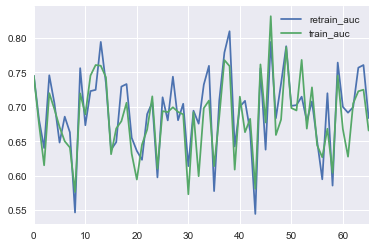

In [342]:
df.plot()

In [343]:
df.mean()

retrain_auc    0.693316
train_auc      0.683690
dtype: float64

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,min_periods=1,center=False).mean()
  if __name__ == '__main__':


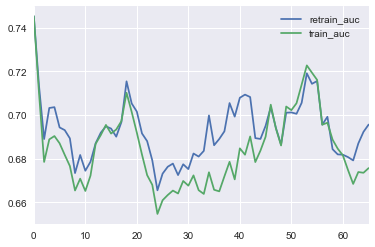

In [350]:
pd.rolling_mean(df, 10, min_periods=1).plot()